<h1>CD3 Population</h1>

In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from datetime import datetime
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
warnings.filterwarnings('ignore')
test_init()

In [3]:
def visualise_manual_threshold(sample_go, parent_population, x, t, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(parent_population).copy(), [x], 'logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data['SSC-A'], bins=500, norm=LogNorm())
    ax.axvline(t, c='r')
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [10]:
def visualise_manual_ellipse(sample_go, parent_population, x, y, centroid, width, height, angle, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(parent_population).copy(), [x, y], 'logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    ellipse = Ellipse(xy=centroid, width=width, height=height,
                              angle=angle, fill=False, edgecolor='r')
    ax.add_patch(ellipse)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

<h2>Manual Gating</h2>

In [5]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [6]:
samples = exp.list_samples()
samples = [x for x in samples if x != 'hc1']

In [26]:
for x in samples:
    print(f'Gating {x}...')
    hc = Gating(exp, x)
    # Debris Gate
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('cells', definition='+')
    child_populations.add_population('debris', definition='-')
    gate_definition = dict(x='FSC-A', y='SSC-A')
    hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                    kwargs=gate_definition, child_populations=child_populations)
    hc.apply('debris_gate', plot_output=False)
    # Lymphocyte Gate
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('lymphocytes', definition='+')
    child_populations.add_population('other_cells', definition='-')
    pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
    gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                          conf=0.99)
    hc.create_gate(gate_name='lymphocyte_gate', parent='cells', class_='MixtureModel', method='gate',
                    kwargs=gate_definition, child_populations=child_populations)
    hc.apply('lymphocyte_gate', plot_output=False)
    print('Complete!')
    hc.save(overwrite=True)
    print('-----------------------------------------------------')

Gating hc4...
Complete!
Saved successfully!
-----------------------------------------------------
Gating hc5...
Complete!
Saved successfully!
-----------------------------------------------------
Gating hc7...
Complete!
Saved successfully!
-----------------------------------------------------
Gating hc9...
Complete!
Saved successfully!
-----------------------------------------------------
Gating hc10...
Complete!
Saved successfully!
-----------------------------------------------------
Gating hc11...
Complete!
Saved successfully!
-----------------------------------------------------
Gating hc12...
Complete!
Saved successfully!
-----------------------------------------------------
Gating hc13...
Complete!
Saved successfully!
-----------------------------------------------------
Gating hc15...
Complete!
Saved successfully!
-----------------------------------------------------
Gating hc16...
Complete!
Saved successfully!
-----------------------------------------------------
Gating hc17...

In [11]:
hc = Gating(exp, 'hc1')

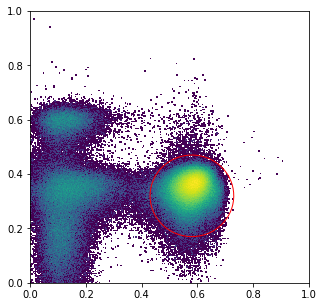

In [19]:
visualise_manual_ellipse(hc, 'lymphocytes', 'CD3', 'L/D', 
                         centroid=(0.58, 0.32), width=0.3, height=0.3, 
                         angle=30, xlim=(0,1), ylim=(0,1))

In [29]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_liveCD3', definition='+')
child_populations.add_population('manual_liveCD3_Neg', definition='-')

gate_definition = dict(x='CD3', y='L/D', centroid=(0.58, 0.32), width=0.3, height=0.3, angle=30)
hc.create_gate(gate_name='manual_liveCD3', parent='lymphocytes', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

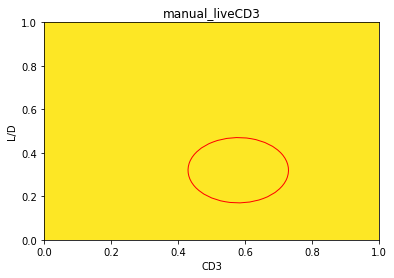

In [30]:
hc.apply('manual_liveCD3')